# Teste de Aderência em Coluna call_started

In [41]:
import statistics as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

import math

import scipy.stats as sp

In [42]:
""" código utilizado no Google Colab para geração de imagens em LaTeX
%%capture
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

plt.rcParams.update({"text.usetex":True})
plt.rcParams["font.family"] = "Times New Roman"
"""

'\n%%capture\n!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended\n\nplt.rcParams.update({"text.usetex":True})\nplt.rcParams["font.family"] = "Times New Roman"\n'

## 1. Leitura da Base de Dados

In [43]:
df = pd.read_csv("simulated_call_centre.csv")
df.sample(10,random_state=40)

,call_id,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard
17737,17738,2021-06-07,17,8:38:01 AM,8:38:01 AM,8:40:33 AM,0,152,True
13331,13332,2021-05-03,16,8:55:30 AM,8:55:30 AM,9:02:36 AM,0,425,True
43274,43275,2021-11-18,111,12:51:31 PM,12:57:24 PM,1:01:59 PM,353,275,False
51004,51005,2021-12-29,130,12:21:06 PM,12:31:08 PM,12:42:43 PM,602,695,False
35200,35201,2021-10-04,78,11:50:43 AM,11:50:43 AM,11:54:07 AM,0,205,True
42104,42105,2021-11-11,226,4:04:55 PM,4:07:35 PM,4:16:40 PM,160,545,False
7665,7666,2021-03-15,59,11:46:40 AM,11:46:40 AM,11:55:12 AM,0,512,True
28266,28267,2021-08-20,81,11:28:05 AM,11:28:05 AM,11:35:12 AM,0,427,True
25900,25901,2021-08-04,212,5:43:25 PM,5:43:25 PM,5:44:04 PM,0,39,True
31600,31601,2021-09-10,195,3:21:07 PM,3:21:07 PM,3:21:11 PM,0,4,True


### 1.1 call_started de String para Integer

In [44]:
def convert_to_seconds(time_string):
    time_obj = datetime.strptime(time_string, "%I:%M:%S %p")
    time_in_seconds = (time_obj.hour * 3600) + (time_obj.minute * 60) + time_obj.second
    return time_in_seconds

In [45]:
day_string = df.groupby('date')['wait_length'].sum().idxmax()
df_day = df[df["date"] == day_string]

df_day['call_started'] = df_day['call_started'].apply(convert_to_seconds)
df_day.drop(columns=["date","daily_caller","call_answered","call_ended"])

C:\Users\Camilo\AppData\Local\Temp\ipykernel_18872\4197959006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['call_started'] = df_day['call_started'].apply(convert_to_seconds)


,call_id,call_started,wait_length,service_length,meets_standard
47359,47360,28800,0,579,True
47360,47361,28939,0,253,True
47361,47362,28974,0,693,True
47362,47363,29198,0,68,True
47363,47364,29360,0,109,True
...,...,...,...,...,...
47651,47652,64077,14,385,True
47652,47653,64318,0,409,True
47653,47654,64335,0,17,True
47654,47655,64343,10,41,True


In [46]:
data = df_day['call_started'].tolist()

## 2. Estatística Descritiva

### 2.1 Medidas de centralidade

In [47]:
call_started_dif = []
for i in range(len(data)):
    if i+1 >= len(data): continue
    call_started_dif.append(data[i+1]-data[i])

In [48]:
print(f'média: {st.mean(data)}')
print(f'moda: {st.mode(data)}')
print(f'mediana: {st.median(data)}')
print(f'máximo: {max(data)}')
print(f'mínimo: {min(data)}')

#Quartis
data_sorted = sorted(data)
Q2 = st.quantiles(data_sorted)
print(f'Quartis: {Q2}')

média: 47114.03367003367
moda: 51037
mediana: 46936
máximo: 64348
mínimo: 28800
Quartis: [39295.5, 46936.0, 56023.0]


### 2.2 Medidas de Dispersão

In [49]:
amp = max(data)-min(data)
print(f'Amplitude: {amp}')

var = st.variance(data)
print(f'Variância: {var}')

std = st.stdev(data)
print(f'Desvio padrão: {std}')

var_coef = (std / var)
print(f'Coeficiente de variação: {var_coef}') ###

ass_coef = st.median(data[:len(data)//2]) / (st.median(data)**3/2) ###
print(f'Coeficiente de Assimetria: {ass_coef}')

Amplitude: 35548
Variância: 101099564.43805169
Desvio padrão: 10054.82791687912
Coeficiente de variação: 9.945471053972909e-05
Coeficiente de Assimetria: 7.600717465317421e-10


## 3. Análise de outliers

In [50]:
# Gerar os quartis
Q = st.quantiles(data_sorted)
A = Q[2] - Q[0]
print(f'Quartis: {Q}')
print(f'Amplitude Interquartil: {A}')

Quartis: [39295.5, 46936.0, 56023.0]
Amplitude Interquartil: 16727.5


In [51]:
moderado = []
extremo = []
for i in data:
    if i < Q[0]-1.5*A or i > Q[2]+1.5*A: moderado.append(i)
    if i < Q[0]-3*A or i > Q[2]+3*A: extremo.append(i)

print(f' {len(moderado)} outlier(s) moderado(s)\n',moderado,'\n\n',f'{len(extremo)} outlier(s) extremo(s)\n',extremo)

 0 outlier(s) moderado(s)
 [] 

 0 outlier(s) extremo(s)
 []


## 4. Teste de Aderência (Método KS)

### 4.1 Histograma

In [52]:
# Histograma
def histograma(data,show_extra=False):
    plt.boxplot(data)
    plt.show()

    k = round(1+3.3*math.log10(len(data)))
    print('Número de classes:',k)

    h = (max(data)-min(data)) / k
    print('Tamanho do intervalo:',h)

    if show_extra:
        c,b=np.histogram(data)
        print("tamanho das classes: ",c)
        print("intervalos:",b)

    plt.hist(data, bins=k,edgecolor="black")
    plt.show()

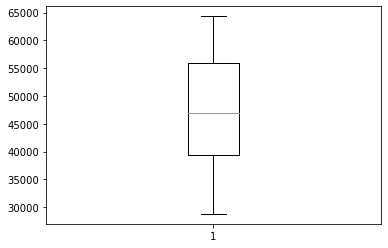

Número de classes: 9
Tamanho do intervalo: 3949.777777777778
tamanho das classes:  [22 29 25 34 35 35 28 28 28 33]
intervalos: [28800.  32354.8 35909.6 39464.4 43019.2 46574.  50128.8 53683.6 57238.4
 60793.2 64348. ]


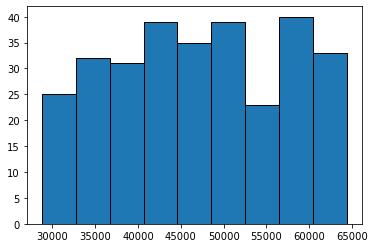

In [53]:
histograma(data,True)

### 4.2 Função do Teste de Kolmogorov-Smirnov

In [54]:
def KS(data,func = None): # método ks para alpha = 0.05
    df = pd.DataFrame()

    list_ = data.copy()

    sum = 0
    FAO = []
    FAON = []
    s_data = sorted(list_)
    size = len(list_)

    VO = list(dict.fromkeys(s_data))
    FO = pd.Series(s_data).value_counts().sort_index(ascending=True).tolist()

    for i in FO:
        sum += i
        FAO.append(sum)
        div = sum/size
        FAON.append(div)

    df['V.O.'] = VO
    df['F.O.'] = FO
    df['F.A.O.'] = FAO
    df['F.A.O.N.'] = FAON

    if func == "uniforme":
        a = df['V.O.'].min()
        b = df['V.O.'].max()

        df['F.T.A.N.'] = sp.uniform.cdf(df['V.O.'].tolist(),loc = a,scale = b)

    elif func == "exponencial":
        mean = st.mean(list_)

        df['F.T.A.N.'] = sp.expon.cdf(df['V.O.'].tolist(),scale = mean)

    elif func == "normal":
        MU = st.mean(list_)
        SIGMA = st.stdev(list_)

        df['F.T.A.N.'] = sp.norm.cdf(df['V.O.'].tolist(),loc=MU,scale=SIGMA)
    else:
        raise TypeError("Função de distribuição inválida")

    df['D'] = abs(df['F.A.O.N.'] - df['F.T.A.N.'])

    # Procurando o alpha, o maior valor da coluna D na tabela

    alpha = max(df['D'])
    print('Valor de α:',alpha)

    D_crit = lambda x: 1.36 / math.sqrt(x)
    print('Valor de D crítico',D_crit(size))

    if D_crit(len(list_)) > alpha:
        print('Como o D crítico > α, então a distribuição aderente ao conjunto de dados.')
    else:
        print('A distribuição não é aderente ao conjunto de dados.')

    return df

In [63]:
ks_df = KS(data,"normal")

Valor de α: 0.07094732766985667
Valor de D crítico 0.0789152040332497
Como o D crítico > α, então a distribuição aderente ao conjunto de dados.


### 4.3 Resultados

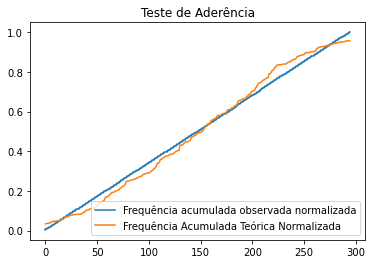

In [64]:
plt.title('Teste de Aderência')
plt.plot(ks_df['F.A.O.N.'],label = 'Frequência acumulada observada normalizada',ds = "steps")
plt.plot(ks_df['F.T.A.N.'],label = 'Frequência Acumulada Teórica Normalizada')
plt.legend()
plt.show()